# Optimized energy scenarios for Val di Non

Author: Michele Urbani ([murbani@fbk.eu](mailto:murbani@fbk.eu))

In this notebook, we replicate the study in {cite:ps}`MAHBUB20171487`.

## Problem description

The original paper considers three scenarios for changing temperatures, i.e.,
2°C, 4°C, and 6°C.
In this notebook, we replicate only the study for a 2°C temperature increase.

### Decision variables

The decision variables are:

1. **PV capacity**: the amount of installed PV capacity is 936 kW and it is
as the lower bound for the variable, whereas the calculated maximum PV capacity
is 40 MW, which is the upper bound.
2. **Heat production technologies**: individual oil, LPG, biomass, and heat
pump production are decision variables expressed as percentages of the total
heat production. **Solar thermal** is also considered and it can be obtained by
oil, LPG, biomass, and heat pumps as a share of the total solar thermal
production.
3. **Electric cars in the system** are a decision variable that defines the
percentage of electric cars in the system. Cars that are not electric adopt
internal combustion engine technologies.

### Constraints

The annual biomass consumption is limited to 98.84 GWh/year.

### Optimization objectives

There are two optimization objectives.

1. **CO$_2$ minimization**: the value of produced CO$_2$ is
``CO2-emission (corrected)`` in EnergyPLAN output.
2. **Annual cost minimization**: the annual cost is the sum of the annual
investment cost, variable operational and maintenance (O&M) cost, fixed
operational and maintenacne cost, and the variable O&M and fixed O&M costs.

## Problem declaration

The paper tackles a multi-period problem, where at each time step the energy
system is optimized according to the decision taken during the previous time
step. A time step represents a year and the years selected for the multi-period
analysis are 2020, 2030, and 2050.

To better control the exectution of the analys, scenarios are defined
independently of the algorithm, and will be provided as parameters during the
initialization stage.

In [1]:
import pandas as pd

common_data = dict(
    co2Coal                         = 95.0,  # unit: kg/GJ
    co2Oil                          = 74.0,
    co2NGas                         = 56.7,
    averageKMPerYearPerCar          = 12900,
    totalKMRunByCars                = 25 * 1e7,
)

scenarios = {
    "2020": dict(
		totalHeatDemand             = 253.70,  # in GWh
		efficiencyConCar            = 0.607,  # KWh/km
		efficiencyEVCar             = 0.169 / 0.85,  # KWh/km; divided by 0.85 (which is "round-trip battery efficiency)
		efficiencyFCEVCar           = 0.334,  # KWh/km
		efficiencyBiomassCHP        = 0.66,
		efficiencyElectrolyzerTrans = 0.74,
		oilBoilerEfficiency         = 0.85,
		nGasBoilerEfficiency        = 0.95,
		biomassBoilerEfficiency     = 0.80,
		COP                         = 4.54,
		coalShare                   = 14.0,
		oilShare                    = 5.6,
		nGasShare                   = 45.0,
		additionalCostPerGWhinKEuro = 136.36,
    ),
    "2030": dict(
		totalHeatDemand             = 249.84,  # in GWh
		efficiencyConCar            = 0.549,  # KWh/km
		efficiencyEVCar             = 0.145 / 0.85,  # KWh/km; divided by 0.85 (which is "round-trip battery efficiency)
		efficiencyFCEVCar           = 0.267,  # KWh/km
		efficiencyBiomassCHP        = 0.66,
		efficiencyElectrolyzerTrans = 0.75,
		oilBoilerEfficiency         = 0.87,
		nGasBoilerEfficiency        = 0.97,
		biomassBoilerEfficiency     = 0.82,
		COP                         = 5.07,
		coalShare                   = 10.4,
		oilShare                    = 4.1,
		nGasShare                   = 33.4,
		additionalCostPerGWhinKEuro = 144.33,
    ),
    "2050": dict(
		totalHeatDemand             = 256.11,  # in GWh
		efficiencyConCar            = 0.497,  # KWh/km
		efficiencyEVCar             = 0.117 / 0.85,  # KWh/km; divided by 0.85 (which is "round-trip battery efficiency)
		efficiencyFCEVCar           = 0.200,  # KWh/km
		efficiencyBiomassCHP        = 0.66,
		efficiencyElectrolyzerTrans = 0.78,
		oilBoilerEfficiency         = 0.89,
		nGasBoilerEfficiency        = 0.99,
		biomassBoilerEfficiency     = 0.84,
		COP                         = 5.46,
		coalShare                   = 3.3,
		oilShare                    = 1.3,
		nGasShare                   = 10.5,
		additionalCostPerGWhinKEuro = 158.37,
    )
}

scenarios = {k: {**common_data, **v} for k, v in scenarios.items()}

df = pd.DataFrame(scenarios)

df.to_csv("vdn-scenarios.csv")


The reference scenario represents the year 2008. We read the parameters file
and store the values for later use in the definition of *transient scenarios*.

In [8]:
from moea.utils import parse_input
from moea.config import ENERGYPLAN_DATA_DIR

reference_scenario = ENERGYPLAN_DATA_DIR / "VdN_SH_2008.txt"

reference_parameters = parse_input(reference_scenario)

{'EnergyPLAN version': '698', 'EnergyUnit': 'GWh/year', 'CapacityUnit': 'kW', 'MonetaryUnit': 'EUR', 'Input_el_demand_Twh': '163.43', 'Input_El_demand_elec_heating_share': '0', 'Input_El_demand_cooling_share': '0', 'input_dh_demand_TWh': '0', 'input_RES1_capacity': '936', 'input_RES2_capacity': '0', 'input_RES1_factor': '0', 'input_RES2_factor': '0', 'input_RES3_capacity': '0', 'input_RES3_factor': '0', 'input_RES4_capacity': '0', 'input_RES4_factor': '0', 'NameRES1': 'Photo Voltaic', 'NameRES2': 'Photo Voltaic', 'NameRES3': 'Offshore Wind', 'NameRES4': 'River Hydro', 'input_dh_ann_gr1': '0', 'input_dh_ann_gr2': '0', 'input_dh_ann_gr3': '0', 'input_solar_ann_gr1': '0', 'input_solar_ann_gr2': '0', 'input_solar_ann_gr3': '0', 'input_cshp_th_gr1': '0', 'input_cshp_th_gr2': '0', 'input_cshp_th_gr3': '0', 'input_AddExport_TWh': '0', 'input_flexible_day_TWh': '0', 'input_flexible_week_TWh': '0', 'input_flexible_4weeks_TWh': '0', 'input_flexible_day_max': '1000', 'input_flexible_week_max': '1

Since the same model is used for the analysis of multiple scenarios, it
must be initialized providing the year and the parameters for the specific
scenario.

In [11]:
import pandas as pd

from moea.models import get_model
from moea.algorithms import get_algorithm

model_name = 'vdn'
algorithm_name = 'NSGA-II'
year = 2020
pop_size = 25

# Read scenarios from file
scenarios = pd.read_csv("vdn-scenarios.csv", index_col=0)
# Use utility functions to get model and algorithm
model = get_model(model_name, year=year, scenario=scenarios[str(year)])
algorithm = get_algorithm(algorithm_name, pop_size=pop_size)


The following cell shows the definition of the model for the Val di None case
study. You can scroll and read the code to check how variable values are
determined and how objective are calculated.

In [9]:
import inspect
from IPython.display import display, Markdown

eval_code = inspect.getsource(model._evaluate)
display(Markdown("```python\n" + eval_code + "```"))

```python
    def _evaluate(self, x, out, *args, **kwargs):
        """
        The objective function and constraints are evaluated here. The
        objective function evaluation consists of a call to EnergyPLAN.
        """
        # Use index naming
        PV = 0
        OIL = 1
        NGAS = 2
        BIOMASS = 3
        MICROCHP = 4
        EV = 5
        OILSOLAR = 6
        NGASSOLAR = 7
        BIOMASSSOLAR = 8
        MICROCHPSOLAR = 9
        HEATSOLAR = 10

        # Heat percentages
        heatPercentages = np.sort(x.T[OIL:EV], axis=1)

        oilBoilerPercentage = heatPercentages[OIL - 1]
        nGasBoilerPercentage = heatPercentages[NGAS - 1] - \
            heatPercentages[OIL - 1]
        biomassBoilerPercentage = heatPercentages[BIOMASS - 1] - \
            heatPercentages[NGAS - 1]
        biomassMicroCHPPercentage = heatPercentages[MICROCHP - 1] - \
            heatPercentages[BIOMASS - 1]
        heatPumpPercentage = 1 - heatPercentages[MICROCHP - 1]

        # Electric car percentage
        EVCarPercentage = x.T[EV]
        conCarpercentage = 1 - EVCarPercentage

        totalKMRunByConCar = (self.scenario["totalKMRunByCars"] *
                              conCarpercentage).astype(int)
        totalKMRunByEVCar = (self.scenario["totalKMRunByCars"] *
                             EVCarPercentage).astype(int)

        totalDieselDemandInGWhForTrns = totalKMRunByConCar * \
            self.scenario["efficiencyConCar"] / 1e6
        totalElecDemandInGWhForTrns = totalKMRunByEVCar * \
            self.scenario["efficiencyEVCar"] / 1e6

        # Solar thermal percentages
        oilSolarPercentage = x.T[OILSOLAR]
        nGasSolarPercentage = x.T[NGASSOLAR]
        biomassSolarPercentage = x.T[BIOMASSSOLAR]
        microCHPSolarPercentage = x.T[MICROCHPSOLAR]
        hpSolarPercentage = x.T[HEATSOLAR]

        # Fuel demand for oil boiler
        oilBoilerFuelDemand = oilBoilerPercentage * \
            self.scenario["totalHeatDemand"] / \
            self.scenario["oilBoilerEfficiency"]
        oilBoilerSolarFuelDemand = oilBoilerFuelDemand * oilSolarPercentage
        # Fuel demand for nGas boiler
        nGasBoilerFuelDemand = nGasBoilerPercentage * \
            self.scenario["totalHeatDemand"] / \
            self.scenario["nGasBoilerEfficiency"]
        nGasBoilerSolarFuelDemand = nGasBoilerFuelDemand * nGasSolarPercentage
        # Fuel demand for biomass boiler
        biomassBoilerFuelDemand = biomassBoilerPercentage * \
            self.scenario["totalHeatDemand"] / \
            self.scenario["biomassBoilerEfficiency"]
        biomassBoilerSolarFuelDemand = biomassBoilerFuelDemand * \
            biomassSolarPercentage
        # Fuel demand for biomass microCHP
        biomassMicroCHPFuelDemand = biomassMicroCHPPercentage * \
            self.scenario["totalHeatDemand"]
        biomassMicroCHPSolarFuelDemand = biomassMicroCHPFuelDemand * \
            microCHPSolarPercentage
        # Fuel demand for heat pump
        heatPumpFuelDemand = heatPumpPercentage * \
            self.scenario["totalHeatDemand"]
        heatPumpSolarFuelDemand = heatPumpFuelDemand * hpSolarPercentage

        # Calculate the number of conventional cars and electric cars
        numberOfConCars = totalDieselDemandInGWhForTrns * 1e6 / \
            (self.scenario["efficiencyConCar"] *
             self.scenario["averageKMPerYearPerCar"] * 1e3)
        numberOfEVCars = totalElecDemandInGWhForTrns * 1e6 / \
            (self.scenario["efficiencyEVCar"] *
             self.scenario["averageKMPerYearPerCar"] * 1e3)

        # Iterate over individuals and create an input file for each one
        # Dump the input vector to a file
        for i, ind in enumerate(x):
            dump_input({
                "input_RES1_capacity": ind[PV].astype(int),
                "input_fuel_Households[2]": oilBoilerFuelDemand[i],
                "input_HH_oilboiler_Solar": oilBoilerSolarFuelDemand[i],
                "input_fuel_Households[3]": nGasBoilerFuelDemand[i],
                "input_HH_ngasboiler_Solar": nGasBoilerSolarFuelDemand[i],
                "input_fuel_Households[4]": biomassBoilerFuelDemand[i],
                "input_HH_bioboiler_Solar": biomassBoilerSolarFuelDemand[i],
                "input_HH_BioCHP_heat": biomassMicroCHPFuelDemand[i],
                "input_HH_bioCHP_solar": biomassMicroCHPSolarFuelDemand[i],
                "input_HH_HP_heat": heatPumpFuelDemand[i],
                "input_HH_HP_Solar": heatPumpSolarFuelDemand[i],
                "input_fuel_Transport[2]": totalDieselDemandInGWhForTrns[i],
                "Input_Size_transport_conventional_cars": numberOfConCars[i],
                "input_transport_TWh": totalElecDemandInGWhForTrns[i],
                "Input_Size_transport_electric_cars": numberOfEVCars[i],
            }, i, self.default_data)

        # Call EnergyPLAN using spool mode; only the input files are needed
        execute_energyplan_spool([f"input{i}.txt" for i in range(len(x))])

        # Parse the output file and store the objective function value in an
        # array
        (localCO2emission, totalVariableCost,
         fixedOperationalCost, investmentCost) = find_values(
            ENERGYPLAN_RESULTS,
            "CO2-emission (total)",
            "Variable costs",
            "Fixed operation costs",
            "Annual Investment costs",
        ).T

        # Retrieve:
        PV = 0  # annual PV electricity
        HYDRO = 1  # annual hydropower
        IMPORT = 2  # annual import
        EXPORT = 3  # annual export
        HH_CHP = 4  # annual HH electricity CHP
        BIOMASS = 5  # annual biomass consumption

        z = np.zeros((6, len(x)))

        for i, res in enumerate(ENERGYPLAN_RESULTS.glob("*.txt")):
            D = parse_output(res)
            annual_lbl = [i for i in D.keys() if 'TOTAL FOR ONE YEAR' in i][0]
            fuel_lbl = [i for i in D.keys() if 'ANNUAL FUEL' in i][0]
            z[HYDRO, i] = float(D[annual_lbl]["Hydro Electr."])
            z[PV, i] = float(D[annual_lbl]["PV Electr."].max())
            z[IMPORT, i] = float(D[annual_lbl]["Import Electr."])
            z[EXPORT, i] = float(D[annual_lbl]["Export Electr."])
            z[HH_CHP, i] = float(D[annual_lbl]["HH-CHP Electr."])
            z[BIOMASS, i] = float(D[fuel_lbl]['TOTAL']["Biomass Consumption"])

        # Compute the first objective: local CO2 emissions

        # Breakdown import electricity cost
        co2InImportedEleCoal = z[IMPORT] * self.scenario["coalShare"] / \
            100 * self.scenario["co2Coal"] * 3600 / 1e6
        co2InImportedEleOil = z[IMPORT] * self.scenario["oilShare"] / \
            100 * self.scenario["co2Oil"] * 3600 / 1e6
        co2InImportedEleNGas = z[IMPORT] * self.scenario["nGasShare"] / \
            100 * self.scenario["co2NGas"] * 3600 / 1e6

        # Calculate local CO2 emissions
        locaCO2Emission = localCO2emission + co2InImportedEleCoal + \
            co2InImportedEleOil + co2InImportedEleNGas

        # Compute the second objective: additional cost

        totalAdditionalCost = (z[HYDRO] + z[PV] + z[IMPORT] - z[EXPORT] + \
                               z[HH_CHP] - totalVariableCost) * \
            self.scenario["additionalCostPerGWhinKEuro"]

        actualAnnualCost = totalVariableCost + fixedOperationalCost + \
            investmentCost + totalAdditionalCost

        # Set objectives
        out["F"] = np.column_stack([locaCO2Emission, actualAnnualCost])

        # CONSTRAINTS

        out["G"] = np.column_stack([
            z[BIOMASS] - 98.84,
        ])
```

In this section, energy planning is optimized for the years 2020, 2030, and
2050. Transient scenarios are identified in the next sections.

In [ ]:
import pickle
from pymoo.optimize import minimize

pop_size = 100

for year in [2020, 2030, 2050]:
    # Declare model and algorithm
    model = get_model(
        model_name,
        year=year,
        scenario=scenarios[str(year)],
        data_file=f"VdN_SH_{year}_Opt_Scenario_2DS_El_mob.txt",
    )
    algorithm = get_algorithm(algorithm_name, pop_size=pop_size)
    # Run optimization
    res = minimize(
        model,
        algorithm,
        ('n_gen', 100),
        seed=1234,
        verbose=True,
    )
    # Save the results to separate the optimization and analysis
    with open(f"results_{model}_{algorithm}_{year}.pkl", "wb") as f:
        pickle.dump(res, f)


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       25 |     13 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |       50 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0272309986 |         ideal
     3 |       75 |     23 |  0.000000E+00 |  0.000000E+00 |  0.0862548253 |         ideal
     4 |      100 |     24 |  0.000000E+00 |  0.000000E+00 |  0.0092270628 |             f
     5 |      125 |     25 |  0.000000E+00 |  0.000000E+00 |  0.0026242856 |             f
     6 |      150 |     25 |  0.000000E+00 |  0.000000E+00 |  0.0055557041 |             f
     7 |      175 |     25 |  0.000000E+00 |  0.000000E+00 |  0.0007867061 |             f
     8 |      200 |     25 |  0.000000E+00 |  0.000000E+00 |  0.0089520474 |             f
     9 |      225 |     25 |  0.000000E+00 |  0.000000E+00 |  0.0007076851 |             f
    10 |      250 |     25 |  0.000000E+00 |  0.000000E+00 |  0.0012882299 |             f

## Results analysis

The Pareto front shows the possible cost-emissions trade-offs that could
potentially be achieved starting from the cofiguration for the year 2008
(represented by the red marker in the plot).

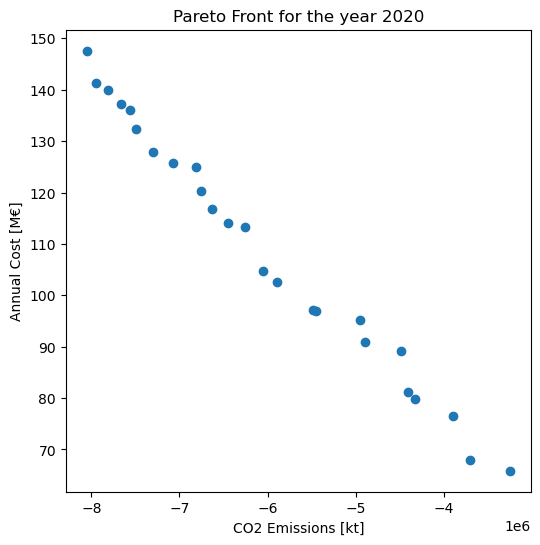

In [13]:
import matplotlib.pyplot as plt
# Print scatter plot with Pareto front

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(res.F[:, 1], res.F[:, 0])
ax.set_xlabel('CO2 Emissions [kt]')
ax.set_ylabel('Annual Cost [M€]')
ax.set_title(f'Pareto Front for the year {year}')
plt.show()


## Selection of optimized target scenarios

The available set of optimized scenarios $P_l$ with cardinality $l$ may include
too many solutions
to be considered for defining a transition between scenarios. Only the a subset
of solutions $P_s$ with cardinality $s$, $s<l$, that are not *too diverse* will
be considered.
The diversity of solutions is measured using the Solow-Polasky distance.
Consider a set $P$ with $n$ number of scenarios $\{S_1,S_2,\ldots,S_n\}$, and
$d (S_i,S_j)$ be the Euclidean distance between scenario $S_i$ and $S_j$.
Euclidean distance between two scenarios is calculated as

$$
d (S_i , S_j) = \sqrt{ \sum_{k = 1}^p (dv_{S_i}^k - dv_{S_j}^k)^2 },
$$

where $dv_{S_i}^k$ is $k$-th decision variable of $S_i$ scenario and $p$ is the
number of decision variables. In addition, considering $M$ is a
$n \times n$ matrix, where each element $m_{i,j}$ is defined by

$$
m_{i,j} = \exp(−\theta \, d (S_i , S_j ))
$$

The constant $\theta$ is a normalizing parameter between distance and number of
individuals. Finally, the Solow and Polasky metric is the summation of all the
elements of the $M^{−1}$ matrix.

The set of optimized target scenarios $P_S$ maximizes the diversity metric

$$
\arg \max_{P_s \subseteq P_l} SP(P_s)
$$

where $SP(P_s)$ is the Solow-Polasky metric.

In [ ]:
import numpy as np


def solow_polasky(X: np.ndarray):
    """
    Parameters
    ----------
    - ``X`` : np.ndarray

        An array with decision variables. Rows are solutions, columns are
        decision variables.
    """
    # Calculate the value of the normalizing scalar theta
    theta = 1 / np.mean(np.linalg.norm(X, axis=-1))
    # Collect pairwise distances between solutions
    distances = np.linalg.norm(X[:, None] - X[None, :], axis=-1)
    M = np.exp(- theta * distances)
    # Compute the inverse of M
    M_inv = np.linalg.inv(M)
    # Return the sum of all the elements in the inverse of M
    return np.sum(M_inv)

# Consider all possible subsets of the Pareto front
# and calculate the Solow-Polasky metric for each subset
from itertools import combinations

# Get the Pareto front
X = res.X
# Initialize the list to store the Solow-Polasky metric for each subset
solow_polasky_values = {}
# Iterate over all possible subset sizes
for subset_size in range(1, len(X)):
    # Iterate over all possible subsets of the Pareto front
    for subset in combinations(range(len(X)), subset_size):
        # Calculate the Solow-Polasky metric for the subset
        solow_polasky_values[subset] = solow_polasky(X[np.array(subset)])

# Get the maximum Solow-Polasky metric value
solow_polasky_max = max(solow_polasky_values)
argmax_subset = np.argmax(solow_polasky_values.values())
solow_polasky_max_subset = X[list(solow_polasky_values.keys())[argmax_subset]]

print(f"Solow-Polasky metric: {solow_polasky_max[0]:.2f}")


TypeError: unsupported format string passed to tuple.__format__

In [24]:
solow_polasky_max_subset

(0,)

## Identification of transient scenarios

Transient scenarios are those that were selected to realize the energy
transition through the years 2008, 2020, 2030, and 2050.
A collection of transient scenarios should enable a smooth transition, i.e.
without abrupt changes from one scenario to the next. The minimal variations
must guarantee to satisfy different targets in terms of emissions.

In [ ]:
# Continue reading section 6 of the paper

### Convergence analysis

The results of the paper {cite:t}`MAHBUB2016140` are used as reference to
measure the quality of the solution. We implement the Inverted Generational
Distance (IGD) {cite:t}`COELLOCOELLO2004688` to quantify the distance from any
point in the set of solutions $Z$ to the closest point in the set of
reference solutions $A$.

$$
IGD(A) = \frac{1}{|Z|} \left( \sum_{i=1}^{|Z|} \hat{d}_i ^{\,p} \right) ^{1/p}
$$

where $\hat{d}_i$ represents the Euclidean distance ($p=2$) from $z_i$ to its
nearest reference point in $A$.

The lower the value of the IGD, the closer the set $A$ to the reference set
$Z$.

In [5]:
from pymoo.indicators.igd import IGD

ind = IGD(res.F)
print("IGD", ind(ref.values))

NameError: name 'ref' is not defined

## References

```{bibliography}
:style: unsrt
```